In [24]:
import findspark
findspark.init()
import pyspark as ps
from pyspark.sql import SQLContext
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql import functions as F
import warnings

Make Spark Context and SQL context

In [6]:
try:
    # create SparkContext on all CPUs available: in my case I have 4 CPUs on my laptop
    sc = ps.SparkContext('local[4]')
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")
    sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: SparkContext already exists in this scope
  


Load from CSV and preview data

In [7]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='false').load('sentiment140dataset/training.1600000.processed.noemoticon.csv')
print(type(df))
df.show(5)

<class 'pyspark.sql.dataframe.DataFrame'>
+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



Clear out useless data and rename useful columns

In [9]:
columns_to_drop = ['_c0', '_c3']
df = df.drop(*columns_to_drop)
df = df.withColumnRenamed('_c1', 'tweet_id').withColumnRenamed('_c2', 'date').withColumnRenamed('_c4', 'username').withColumnRenamed('_c5', 'tweet')
df.show(5)

+----------+--------------------+---------------+--------------------+
|  tweet_id|                date|       username|               tweet|
+----------+--------------------+---------------+--------------------+
|1467810369|Mon Apr 06 22:19:...|_TheSpecialOne_|@switchfoot http:...|
|1467810672|Mon Apr 06 22:19:...|  scotthamilton|is upset that he ...|
|1467810917|Mon Apr 06 22:19:...|       mattycus|@Kenichan I dived...|
|1467811184|Mon Apr 06 22:19:...|        ElleCTF|my whole body fee...|
|1467811193|Mon Apr 06 22:19:...|         Karoli|@nationwideclass ...|
+----------+--------------------+---------------+--------------------+
only showing top 5 rows



Check that there are no NA values (there shouldn't be any)

In [11]:
print(f"before dropping na {df.count()}")
df.dropna()
print(f"after dropping na {df.count()}")

before dropping na 1600000
after dropping na 1600000


# Check tweet frequency over date

Convert date column from String to Timestamp

In [26]:
print(df.dtypes)
print(df.select('date').show(5))
form = 'EEE MMM dd H:m:s z yyyy'
df2 = df.withColumn('date', F.unix_timestamp('date', form).cast('timestamp'))
df2.show(5)

[('tweet_id', 'string'), ('date', 'string'), ('username', 'string'), ('tweet', 'string')]
+--------------------+
|                date|
+--------------------+
|Mon Apr 06 22:19:...|
|Mon Apr 06 22:19:...|
|Mon Apr 06 22:19:...|
|Mon Apr 06 22:19:...|
|Mon Apr 06 22:19:...|
+--------------------+
only showing top 5 rows

None
+----------+-------------------+---------------+--------------------+
|  tweet_id|               date|       username|               tweet|
+----------+-------------------+---------------+--------------------+
|1467810369|2009-04-07 01:19:45|_TheSpecialOne_|@switchfoot http:...|
|1467810672|2009-04-07 01:19:49|  scotthamilton|is upset that he ...|
|1467810917|2009-04-07 01:19:53|       mattycus|@Kenichan I dived...|
|1467811184|2009-04-07 01:19:57|        ElleCTF|my whole body fee...|
|1467811193|2009-04-07 01:19:57|         Karoli|@nationwideclass ...|
+----------+-------------------+---------------+--------------------+
only showing top 5 rows



Now that we know df2 is correct, make df = df2

In [39]:
df = df2

Make linegraph of tweets over time

+------------+------+
|no_timestamp| count|
+------------+------+
|  2009-04-07| 20671|
|  2009-04-17|   499|
|  2009-04-18| 18327|
|  2009-04-19| 31148|
|  2009-04-20| 18275|
|  2009-04-21| 11105|
|  2009-05-01|  1706|
|  2009-05-02| 29390|
|  2009-05-03| 33363|
|  2009-05-04| 21505|
|  2009-05-09|  5755|
|  2009-05-10| 31177|
|  2009-05-11|   836|
|  2009-05-12|  4186|
|  2009-05-13|   529|
|  2009-05-14| 20997|
|  2009-05-16|  3496|
|  2009-05-17| 39441|
|  2009-05-18| 42832|
|  2009-05-22| 41206|
|  2009-05-23|   169|
|  2009-05-25|   169|
|  2009-05-27| 11619|
|  2009-05-28|  2019|
|  2009-05-29| 76020|
|  2009-05-30|101619|
|  2009-05-31|104088|
|  2009-06-01|100462|
|  2009-06-02| 66799|
|  2009-06-03| 53054|
|  2009-06-04|  4638|
|  2009-06-05| 48541|
|  2009-06-06|111056|
|  2009-06-07|109279|
|  2009-06-08|  1111|
|  2009-06-14|   500|
|  2009-06-15|103138|
|  2009-06-16| 76266|
|  2009-06-17| 44060|
|  2009-06-18| 43061|
|  2009-06-19| 43264|
|  2009-06-20| 45335|
|  2009-06

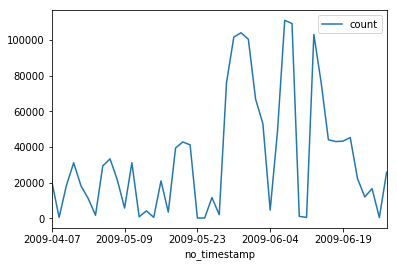

In [66]:
import matplotlib.pyplot as plt
dates = df.select(F.date_format('date','yyyy-MM-dd').alias('no_timestamp')).groupby('no_timestamp').count().sort(F.col('no_timestamp'))
print(dates.show(dates.count()))
dates.toPandas().plot(kind='line',x='no_timestamp',y='count')

Lets try a bar graph because I spent too long trying to figure out how this works

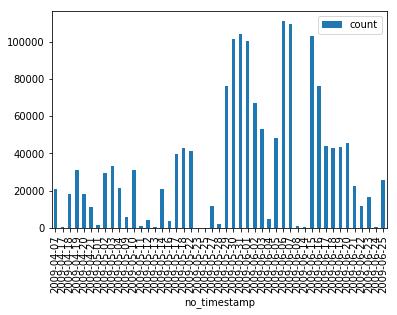

In [69]:
dates.toPandas().plot(kind='bar',x='no_timestamp')

# Prepare Tweets for OLDA

Remove stopwords 

In [ ]:
more_then_3_charachters = [word for word in cv_tmp_model.vocabulary if len(word) <= 3]
contains_digits = [word for word in cv_tmp_model.vocabulary if any(char.isdigit() for char in word)]

In [77]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
prep_df = tokenizer.transform(df)
cv_prep = CountVectorizer(inputCol="words", outputCol="prep")
cv_model = cv_prep.fit(prep_df)
ready_df = cv_model.transform(prep_df)
# stopWords = [word for word in cv_prep.vocabulary if any(char.isdigit() for char in word)]
# remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords = stopwords)
# prep_df = remover.transform(prep_df)

In [93]:
pand = ready_df.toPandas()
print(pand)

Py4JJavaError: An error occurred while calling o819.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 207.0 failed 1 times, most recent failure: Lost task 3.0 in stage 207.0 (TID 10013, localhost, executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1877)
	at java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1786)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1189)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:43)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:100)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:456)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:989)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1877)
	at java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1786)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1189)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:43)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:100)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:456)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 58924)
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/accumulators.py", line 269, in handle
    

In [94]:
trainable = ready_df.select('tweet_id', 'prep').rdd.map(lambda x,y: [x,Vectors.fromML(y)]).cache()
# print(trainable.take(10))
model = LDA.train(trainable, k=5, seed=1, optimizer="online")
exit(0)
#Print the topics in the model
topics = model.describeTopics(maxTermsPerTopic = 15)
for x, topic in enumerate(topics):
    print('topic nr: ' + str(x))
    words = topic[0]
    weights = topic[1]
    for n in range(len(words)):
        print(cv_prep.vocabulary[words[n]] + ' ' + str(weights[n]))

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1152, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 54] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

D

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

D

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

D

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

D

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

D

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

D

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65022)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

D

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:65022)